In [2]:
#NAME: PULAK NATH
#CERTIFICATION CODE: TCRIL01R16
#EMAIL: nathpulak48002507@gmail.com
#BATCH: ARTIFICIAL INTELLIGENCE
#ASSIGNMENT - DEEP LEARNING
#PROJECT NAME- DETERMINING DIFFERENT ENTITY IN FOOD DELIVERY DATA

In [50]:
# downloading spacy language model
!pip install spacy==2.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 7.2 MB/s 
     |████████████████████████████████| 2.1 MB 34.3 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.4.0 requires spacy<3.5.0,>=3.4.0, but you have spacy 2.3.1 which is incompatible.
en-core-web-lg 3.4.0 requires spacy<3.5.0,>=3.4.0, but you have spacy 2.3.1 which is incompatible.


In [1]:
# importing libraries
import en_core_web_sm
import pandas as pd
import re
import random
import spacy
from spacy.util import minibatch, compounding
import warnings
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (3.4.0) requires spaCy v3.4 and is incompatible with the current spaCy version (2.3.1). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
# Generating Food Data 

In [3]:
# USDA's Branded Food's dataset: 
#https://fdc.nal.usda.gov/fdc-datasets/FoodData_Central_foundation_food_csv_2022-04-28.zip

In [4]:
# Preparing the food data

In [5]:
# read in the food csv file
food_df = pd.read_csv("/content/drive/MyDrive/INTERNSHIPS/TCR Internship (AI)/Final Project/food.csv")

# print row and column information
food_df.head()

,fdc_id,data_type,description,food_category_id,publication_date
0,1105904,branded_food,WESSON Vegetable Oil 1 GAL,NaN,2020-11-13
1,1105905,branded_food,SWANSON BROTH BEEF,NaN,2020-11-13
2,1105906,branded_food,CAMPBELL'S SLOW KETTLE SOUP CLAM CHOWDER,NaN,2020-11-13
3,1105907,branded_food,CAMPBELL'S SLOW KETTLE SOUP CHEESE BROCCOLI,NaN,2020-11-13
4,1105908,branded_food,SWANSON BROTH CHICKEN,NaN,2020-11-13


In [6]:
# print the size 
food_df["description"].size

1142610

In [7]:
# disqualify foods with special characters, lowercase and extract results from "description" column
foods = food_df[food_df["description"].str.contains("[^a-zA-Z ]") == False]["description"].apply(lambda food: food.lower())

# filter out foods with more than 3 words, drop any duplicates
foods = foods[foods.str.split().apply(len) <= 3].drop_duplicates()

# print the remaining size
foods.size

40508

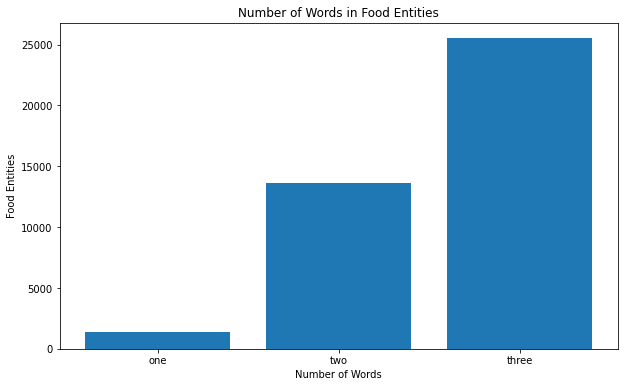

In [8]:
# find one-worded, two-worded and three-worded foods
one_worded_foods = foods[foods.str.split().apply(len) == 1]
two_worded_foods = foods[foods.str.split().apply(len) == 2]
three_worded_foods = foods[foods.str.split().apply(len) == 3]

# create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([1, 2, 3], [one_worded_foods.size, two_worded_foods.size, three_worded_foods.size])

# label the x-axis instances
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["one", "two", "three"])

# set the title and the xy-axis labels
plt.title("Number of Words in Food Entities")
plt.xlabel("Number of Words")
plt.ylabel("Food Entities")

# display the plot
plt.show()

In [9]:
# total number of foods
total_num_foods = round(one_worded_foods.size / 45 * 100)

# shuffle the 2-worded and 3-worded foods since we'll be slicing them
two_worded_foods = two_worded_foods.sample(frac=1)
three_worded_foods = three_worded_foods.sample(frac=1)

# append the foods together 
foods = one_worded_foods.append(two_worded_foods[:round(total_num_foods * 0.30)]).append(three_worded_foods[:round(total_num_foods * 0.25)])

# print the resulting sizes
for i in range(3):
    print(f"{i+1}-worded food entities:", foods[foods.str.split().apply(len) == i + 1].size)

1-worded food entities: 1365
2-worded food entities: 910
3-worded food entities: 758


In [10]:
food_templates = [
    "I ate my {}",
    "I'm eating a {}",
    "I just ate a {}",
    "I only ate the {}",
    "I'm done eating a {}",
    "I've already eaten a {}",
    "I just finished my {}",
    "When I was having lunch I ate a {}",
    "I had a {} and a {} today",
    "I ate a {} and a {} for lunch",
    "I made a {} and {} for lunch",
    "I ate {} and {}",
    "today I ate a {} and a {} for lunch",
    "I had {} with my husband last night",
    "I brought you some {} on my birthday",
    "I made {} for yesterday's dinner",
    "last night, a {} was sent to me with {}",
    "I had {} yesterday and I'd like to eat it anyway",
    "I ate a couple of {} last night",
    "I had some {} at dinner last night",
    "Last night, I ordered some {}",
    "I made a {} last night",
    "I had a bowl of {} with {} and I wanted to go to the mall today",
    "I brought a basket of {} for breakfast this morning",
    "I had a bowl of {}",
    "I ate a {} with {} in the morning",
    "I made a bowl of {} for my breakfast",
    "There's {} for breakfast in the bowl this morning",
    "This morning, I made a bowl of {}",
    "I decided to have some {} as a little bonus",
    "I decided to enjoy some {}",
    "I've decided to have some {} for dessert",
    "I had a {}, a {} and {} at home",
    "I took a {}, {} and {} on the weekend",
    "I ate a {} with {} and {} just now",
    "Last night, I ate an {} with {} and {}",
    "I tasted some {}, {} and {} at the office",
    "There's a basket of {}, {} and {} that I consumed",
    "I devoured a {}, {} and {}",
    "I've already had a bag of {}, {} and {} from the fridge"
]

In [11]:
data = [
    ("I love chicken", [(8, 13, "FOOD")]),
    ... 
]

In [12]:
# create dictionaries to store the generated food combinations. Do note that one_food != one_worded_food. one_food == "barbecue sauce", one_worded_food == "sauce"
TRAIN_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

TEST_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

# one_food, two_food, and three_food combinations will be limited to 167 sentences
FOOD_SENTENCE_LIMIT = 167

# helper function for deciding what dictionary and subsequent array to append the food sentence on to
def get_food_data(count):
    return {
        1: TRAIN_FOOD_DATA["one_food"] if len(TRAIN_FOOD_DATA["one_food"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["one_food"],
        2: TRAIN_FOOD_DATA["two_foods"] if len(TRAIN_FOOD_DATA["two_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["two_foods"],
        3: TRAIN_FOOD_DATA["three_foods"] if len(TRAIN_FOOD_DATA["three_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["three_foods"],
    }[count]

# the pattern to replace from the template sentences
pattern_to_replace = "{}"

# shuffle the data before starting
foods = foods.sample(frac=1)

# the count that helps us decide when to break from the for loop
food_entity_count = foods.size - 1

# start the while loop, ensure we don't get an index out of bounds error
while food_entity_count >= 2:
    entities = []

    # pick a random food template
    sentence = food_templates[random.randint(0, len(food_templates) - 1)]

    # find out how many braces "{}" need to be replaced in the template
    matches = re.findall(pattern_to_replace, sentence)

    # for each brace, replace with a food entity from the shuffled food data
    for match in matches:
        food = foods.iloc[food_entity_count]
        food_entity_count -= 1

        # replace the pattern, but then find the match of the food entity we just inserted
        sentence = sentence.replace(match, food, 1)
        match_span = re.search(food, sentence).span()

        # use that match to find the index positions of the food entity in the sentence, append
        entities.append((match_span[0], match_span[1], "FOOD"))

    # append the sentence and the position of the entities to the correct dictionary and array
    get_food_data(len(matches)).append((sentence, {"entities": entities}))
  

In [13]:
# create dictionaries to store the generated food combinations. Do note that one_food != one_worded_food. one_food == "barbecue sauce", one_worded_food == "sauce"
TRAIN_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

TEST_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

# one_food, two_food, and three_food combinations will be limited to 167 sentences
FOOD_SENTENCE_LIMIT = 167

# helper function for deciding what dictionary and subsequent array to append the food sentence on to
def get_food_data(count):
    return {
        1: TRAIN_FOOD_DATA["one_food"] if len(TRAIN_FOOD_DATA["one_food"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["one_food"],
        2: TRAIN_FOOD_DATA["two_foods"] if len(TRAIN_FOOD_DATA["two_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["two_foods"],
        3: TRAIN_FOOD_DATA["three_foods"] if len(TRAIN_FOOD_DATA["three_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["three_foods"],
    }[count]

# the pattern to replace from the template sentences
pattern_to_replace = "{}"

# shuffle the data before starting
foods = foods.sample(frac=1)

# the count that helps us decide when to break from the for loop
food_entity_count = foods.size - 1

# start the while loop, ensure we don't get an index out of bounds error
while food_entity_count >= 2:
    entities = []

    # pick a random food template
    sentence = food_templates[random.randint(0, len(food_templates) - 1)]

    # find out how many braces "{}" need to be replaced in the template
    matches = re.findall(pattern_to_replace, sentence)

    # for each brace, replace with a food entity from the shuffled food data
    for match in matches:
        food = foods.iloc[food_entity_count]
        food_entity_count -= 1

        # replace the pattern, but then find the match of the food entity we just inserted
        sentence = sentence.replace(match, food, 1)
        match_span = re.search(food, sentence).span()

        # use that match to find the index positions of the food entity in the sentence, append
        entities.append((match_span[0], match_span[1], "FOOD"))

    # append the sentence and the position of the entities to the correct dictionary and array
    get_food_data(len(matches)).append((sentence, {"entities": entities}))
  

167 one_food sentences: ('This morning, I made a bowl of fuel snacks', {'entities': [(31, 42, 'FOOD')]})
167 two_foods sentences: ('I made a traditional white bread and deli rolls for lunch', {'entities': [(9, 32, 'FOOD'), (37, 47, 'FOOD')]})
167 three_foods sentences: ("There's a basket of thin enriched bread, mini buns and cardamom that I consumed", {'entities': [(20, 39, 'FOOD'), (41, 50, 'FOOD'), (55, 63, 'FOOD')]})


In [14]:
for key in TEST_FOOD_DATA:
    print("{} {} items: {}".format(len(TEST_FOOD_DATA[key]), key, TEST_FOOD_DATA[key][0]))

989 one_food items: ('I had nopalitos with my husband last night', {'entities': [(6, 15, 'FOOD')]})
207 two_foods items: ('I ate yogurt creme and habanero pepper jelly', {'entities': [(6, 18, 'FOOD'), (23, 44, 'FOOD')]})
209 three_foods items: ('I had a nazook pastry, a drink and flounder fillet at home', {'entities': [(8, 21, 'FOOD'), (25, 30, 'FOOD'), (35, 50, 'FOOD')]})


In [15]:
#  Generating Revision Data

In [16]:
# Preparing the revision data

In [17]:
npr_df = pd.read_csv("/content/drive/MyDrive/INTERNSHIPS/TCR Internship (AI)/Final Project/npr.csv")

# print row and column information
npr_df.head()

,Article
0,"In the Washington of 2016, even when the polic..."
1,Donald Trump has used Twitter — his prefe...
2,Donald Trump is unabashedly praising Russian...
3,"Updated at 2:50 p. m. ET, Russian President Vl..."
4,"From photography, illustration and video, to d..."


In [20]:
# create an nlp object as we'll use this to seperate the sentences and identify existing entities
import spacy.cli
spacy.cli.download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [21]:
revision_texts = []

# convert the articles to spacy objects to better identify the sentences. Disabled unneeded components. # takes ~ 4 minutes
for doc in nlp.pipe(npr_df["Article"][:6000], batch_size=30, disable=["tagger", "ner"]):
    for sentence in doc.sents:
        if  40 < len(sentence.text) < 80:
            # some of the sentences had excessive whitespace in between words, so we're trimming that
            revision_texts.append(" ".join(re.split("\s+", sentence.text, flags=re.UNICODE)))

In [22]:
revisions = []

# Use the existing spaCy model to predict the entities, then append them to revision
for doc in nlp.pipe(revision_texts, batch_size=50, disable=["tagger", "parser"]):
    
    # don't append sentences that have no entities
    if len(doc.ents) > 0:
        revisions.append((doc.text, {"entities": [(e.start_char, e.end_char, e.label_) for e in doc.ents]}))

In [23]:
# Split train and test revision data

In [24]:
# print an example of the revision sentence
print(revisions[0][0])

# print an example of the revision data
print(revisions[0][1])

And in that sense, this year shows little sign of ending on Dec. 31.
{'entities': [(19, 28, 'DATE'), (60, 67, 'DATE')]}


In [25]:
# create arrays to store the revision data
TRAIN_REVISION_DATA = []
TEST_REVISION_DATA = []

# create dictionaries to keep count of the different entities
TRAIN_ENTITY_COUNTER = {}
TEST_ENTITY_COUNTER = {}

# This will help distribute the entities (i.e. we don't want 1000 PERSON entities, but only 80 ORG entities)
REVISION_SENTENCE_SOFT_LIMIT = 100

# helper function for incrementing the revision counters
def increment_revision_counters(entity_counter, entities):
    for entity in entities:
        label = entity[2]
        if label in entity_counter:
            entity_counter[label] += 1
        else:
            entity_counter[label] = 1

random.shuffle(revisions)
for revision in revisions:
    # get the entities from the revision sentence
    entities = revision[1]["entities"]

    # simple hack to make sure spaCy entities don't get too one-sided
    should_append_to_train_counter = 0
    for _, _, label in entities:
        if label in TRAIN_ENTITY_COUNTER and TRAIN_ENTITY_COUNTER[label] > REVISION_SENTENCE_SOFT_LIMIT:
            should_append_to_train_counter -= 1
        else:
            should_append_to_train_counter += 1

    # simple switch for deciding whether to append to train data or test data
    if should_append_to_train_counter >= 0:
        TRAIN_REVISION_DATA.append(revision)
        increment_revision_counters(TRAIN_ENTITY_COUNTER, entities)
    else:
        TEST_REVISION_DATA.append(revision)
        increment_revision_counters(TEST_ENTITY_COUNTER, entities)

In [26]:
{'DATE': 212,
 'GPE': 164,
 'CARDINAL': 195,
 'PERSON': 254,
 'LANGUAGE': 85,
 'ORG': 192,
 'WORK_OF_ART': 103,
 'TIME': 108,
 'ORDINAL': 110,
 'PERCENT': 101,
 'NORP': 115,
 'LOC': 106,
 'MONEY': 102,
 'QUANTITY': 101,
 'EVENT': 101,
 'PRODUCT': 101,
 'LAW': 95,
 'FAC': 101}

{'DATE': 212,
 'GPE': 164,
 'CARDINAL': 195,
 'PERSON': 254,
 'LANGUAGE': 85,
 'ORG': 192,
 'WORK_OF_ART': 103,
 'TIME': 108,
 'ORDINAL': 110,
 'PERCENT': 101,
 'NORP': 115,
 'LOC': 106,
 'MONEY': 102,
 'QUANTITY': 101,
 'EVENT': 101,
 'PRODUCT': 101,
 'LAW': 95,
 'FAC': 101}

In [27]:
{'PERSON': 14027,
 'ORG': 10360,
 'DATE': 7153,
 'GPE': 5661,
 'NORP': 2739,
 'CARDINAL': 5397,
 'QUANTITY': 171,
 'PERCENT': 441,
 'TIME': 794,
 'FAC': 152,
 'LOC': 559,
 'ORDINAL': 1151,
 'MONEY': 560,
 'WORK_OF_ART': 592,
 'PRODUCT': 119,
 'EVENT': 104,
 'LANGUAGE': 24,
 'LAW': 12}

{'PERSON': 14027,
 'ORG': 10360,
 'DATE': 7153,
 'GPE': 5661,
 'NORP': 2739,
 'CARDINAL': 5397,
 'QUANTITY': 171,
 'PERCENT': 441,
 'TIME': 794,
 'FAC': 152,
 'LOC': 559,
 'ORDINAL': 1151,
 'MONEY': 560,
 'WORK_OF_ART': 592,
 'PRODUCT': 119,
 'EVENT': 104,
 'LANGUAGE': 24,
 'LAW': 12}

In [28]:
# Training the NER Model

In [29]:
# combine the food training data
TRAIN_FOOD_DATA_COMBINED = TRAIN_FOOD_DATA["one_food"] + TRAIN_FOOD_DATA["two_foods"] + TRAIN_FOOD_DATA["three_foods"]

# print the length of the food training data
print("FOOD", len(TRAIN_FOOD_DATA_COMBINED))

# print the length of the revision training data
print("REVISION", len(TRAIN_REVISION_DATA))

# join and print the combined length
TRAIN_DATA = TRAIN_REVISION_DATA + TRAIN_FOOD_DATA_COMBINED
print("COMBINED", len(TRAIN_DATA))

FOOD 501
REVISION 1511
COMBINED 2012


In [30]:
# add NER to the pipeline and the new label
ner = nlp.get_pipe("ner")
ner.add_label("FOOD")

# get the names of the components we want to disable during training
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

# start the training loop, only training NER
epochs = 30
optimizer = nlp.resume_training()
with nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
    warnings.filterwarnings("once", category=UserWarning, module='spacy')
    sizes = compounding(1.0, 4.0, 1.001)
    
    # batch up the examples using spaCy's minibatc
    for epoch in range(epochs):
        examples = TRAIN_DATA
        random.shuffle(examples)
        batches = minibatch(examples, size=sizes)
        losses = {}
        
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)

        print("Losses ({}/{})".format(epoch + 1, epochs), losses)

/usr/local/lib/python3.7/dist-packages/spacy/language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "There's a basket of applesauce , blast cola and re..." with entities "[(20, 31, 'FOOD'), (33, 43, 'FOOD'), (48, 57, 'FOO...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)
/usr/local/lib/python3.7/dist-packages/spacy/language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "I ate a salsacuse with marinade  and malt just now" with entities "[(8, 17, 'FOOD'), (23, 32, 'FOOD'), (37, 41, 'FOOD...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)
/usr/local/lib/python3.7/dist-packages/spacy/language.py:482: UserWarning: [W030] Some entities could not be aligned in

Losses (1/30) {'ner': 16141.074182556786}
Losses (2/30) {'ner': 15100.640285312864}
Losses (3/30) {'ner': 14598.520053639077}
Losses (4/30) {'ner': 14681.15871394705}
Losses (5/30) {'ner': 14378.04642756842}
Losses (6/30) {'ner': 14362.669783049903}
Losses (7/30) {'ner': 14231.482577875024}
Losses (8/30) {'ner': 14192.62708273041}
Losses (9/30) {'ner': 14067.155414268025}
Losses (10/30) {'ner': 14210.909468730038}
Losses (11/30) {'ner': 13991.059468667256}
Losses (12/30) {'ner': 14157.769489249215}
Losses (13/30) {'ner': 14007.112681735074}
Losses (14/30) {'ner': 13880.934393891861}
Losses (15/30) {'ner': 13905.5669521111}
Losses (16/30) {'ner': 13844.921431964176}
Losses (17/30) {'ner': 13910.961570164072}
Losses (18/30) {'ner': 13571.614640180524}
Losses (19/30) {'ner': 13773.026946463313}
Losses (20/30) {'ner': 13792.831707649748}
Losses (21/30) {'ner': 13868.90286010434}
Losses (22/30) {'ner': 13901.526074738485}
Losses (23/30) {'ner': 14055.503904130659}
Losses (24/30) {'ner': 136

In [31]:
# Evaluating the Model

In [33]:
# display sentence involving original entities
spacy.displacy.render(nlp("Apple is looking at buying U.K. startup for $1 billion"), style="ent")

'<div class="entities" style="line-height: 2.5; direction: ltr">\n<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    Apple\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">ORG</span>\n</mark>\n is looking at buying \n<mark class="entity" style="background: #feca74; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    U.K.\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">GPE</span>\n</mark>\n startup for \n<mark class="entity" style="background: #e4e7d2; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    $1 billion\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35e

In [34]:
# display sentences involving target entity
spacy.displacy.render(nlp("I had a hamburger and chips for lunch today."), style="ent")
spacy.displacy.render(nlp("I decided to have chocolate ice cream as a little treat for myself."), style="ent")
spacy.displacy.render(nlp("I ordered basmati rice, leaf spinach and cheese from Tesco yesterday"), style="ent")

'<div class="entities" style="line-height: 2.5; direction: ltr">I ordered \n<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    basmati rice\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">FOOD</span>\n</mark>\n, \n<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    leaf spinach\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">FOOD</span>\n</mark>\n and \n<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    cheese\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transf

In [35]:
#Evaluating the Model

In [36]:
# display sentence involving original entities
spacy.displacy.render(nlp("Apple is looking at buying U.K. startup for $1 billion"), style="ent")

'<div class="entities" style="line-height: 2.5; direction: ltr">\n<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    Apple\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">ORG</span>\n</mark>\n is looking at buying \n<mark class="entity" style="background: #feca74; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    U.K.\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">GPE</span>\n</mark>\n startup for \n<mark class="entity" style="background: #e4e7d2; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    $1 billion\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35e

In [ ]:
# display sentences involving target entity
spacy.displacy.render(nlp("I had a hamburger and chips for lunch today."), style="ent")
spacy.displacy.render(nlp("I decided to have chocolate ice cream as a little treat for myself."), style="ent")
spacy.displacy.render(nlp("I ordered basmati rice, leaf spinach and cheese from Tesco yesterday"), style="ent")

'<div class="entities" style="line-height: 2.5; direction: ltr">I ordered basmati rice, leaf spinach and cheese from \n<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    Tesco\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">ORG</span>\n</mark>\n \n<mark class="entity" style="background: #bfe1d9; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    yesterday\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">DATE</span>\n</mark>\n</div>'

In [37]:
#Evaluating Food Entities

In [37]:
# dictionary to hold our evaluation data
food_evaluation = {
    "one_food": {
        "correct": 0,
        "total": 0,
    },
    "two_foods": {
        "correct": 0,
        "total": 0
    },
    "three_foods": {
        "correct": 0,
        "total": 0
    }
}

word_evaluation = {
    "1_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "2_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "3_worded_foods": {
        "correct": 0,
        "total": 0
    }
}

# loop over data from our test food set (3 keys in total)
for key in TEST_FOOD_DATA:
    foods = TEST_FOOD_DATA[key]

    for food in foods:
        # extract the sentence and correct food entities according to our test data
        sentence = food[0]
        entities = food[1]["entities"]

        # for each entity, use our updated model to make a prediction on the sentence
        for entity in entities:
            doc = nlp(sentence)
            correct_text = sentence[entity[0]:entity[1]]
            n_worded_food =  len(correct_text.split())

            # if we find that there's a match for predicted entity and predicted text, increment correct counters
            for ent in doc.ents:
                if ent.label_ == entity[2] and ent.text == correct_text:
                    food_evaluation[key]["correct"] += 1
                    if n_worded_food > 0:
                        word_evaluation[f"{n_worded_food}_worded_foods"]["correct"] += 1
                    
                    # this break is important, ensures that we're not double counting on a correct match
                    break
            
            #  increment total counters after each entity loop
            food_evaluation[key]["total"] += 1
            if n_worded_food > 0:
                word_evaluation[f"{n_worded_food}_worded_foods"]["total"] += 1

In [38]:
for key in word_evaluation:
    correct = word_evaluation[key]["correct"]
    total = word_evaluation[key]["total"]

    print(f"{key}: {correct / total * 100:.2f}%")

food_total_sum = 0
food_correct_sum = 0

print("---")
for key in food_evaluation:
    correct = food_evaluation[key]["correct"]
    total = food_evaluation[key]["total"]
    
    food_total_sum += total
    food_correct_sum += correct

    print(f"{key}: {correct / total * 100:.2f}%")

print(f"\nTotal: {food_correct_sum/food_total_sum * 100:.2f}%")

1_worded_foods: 90.91%
2_worded_foods: 95.33%
3_worded_foods: 92.66%
---
one_food: 90.50%
two_foods: 94.69%
three_foods: 94.74%

Total: 92.66%


In [39]:
#Evaluating Existing Entities

In [40]:
# dictionary which will be populated with the entities and result information
entity_evaluation = {}

# helper function to udpate the entity_evaluation dictionary
def update_results(entity, metric):
    if entity not in entity_evaluation:
        entity_evaluation[entity] = {"correct": 0, "total": 0}
    
    entity_evaluation[entity][metric] += 1

# same as before, see if entities from test set match what spaCy currently predicts
for data in TEST_REVISION_DATA:
    sentence = data[0]
    entities = data[1]["entities"]

    for entity in entities:
        doc = nlp(sentence)
        correct_text = sentence[entity[0]:entity[1]]

        for ent in doc.ents:
            if ent.label_ == entity[2] and ent.text == correct_text:
                update_results(ent.label_, "correct")
                break

        update_results(entity[2], "total")

In [41]:
sum_total = 0
sum_correct = 0

for entity in entity_evaluation:
    total = entity_evaluation[entity]["total"]
    correct = entity_evaluation[entity]["correct"]

    sum_total += total
    sum_correct += correct
    
    print("{} | {:.2f}%".format(entity, correct / total * 100))

print()
print("Overall accuracy: {:.2f}%".format(sum_correct / sum_total * 100))

PERSON | 79.39%
ORG | 59.51%
DATE | 64.28%
GPE | 82.12%
ORDINAL | 97.22%
TIME | 62.69%
CARDINAL | 82.22%
MONEY | 85.36%
NORP | 83.74%
LOC | 66.07%
WORK_OF_ART | 61.25%
EVENT | 56.73%
PERCENT | 90.23%
FAC | 66.89%
QUANTITY | 70.18%
LANGUAGE | 92.31%
PRODUCT | 49.58%
LAW | 75.00%

Overall accuracy: 73.72%


In [42]:
# Saving the model

In [44]:
nlp.meta["name"] = "food_entity_extractor_v2"
nlp.to_disk("v2")

In [ ]:
# The results we arrived at is the following for our FOOD entities:
"""
1_worded_foods: 90.91%
2_worded_foods: 95.33%
3_worded_foods: 92.66%
---
one_food: 90.50%
two_foods: 94.69%
three_foods: 94.74%

Total: 92.66%
"""

In [ ]:
# The results for our existing entities:
"""
PERSON | 79.39%
ORG | 59.51%
DATE | 64.28%
GPE | 82.12%
ORDINAL | 97.22%
TIME | 62.69%
CARDINAL | 82.22%
MONEY | 85.36%
NORP | 83.74%
LOC | 66.07%
WORK_OF_ART | 61.25%
EVENT | 56.73%
PERCENT | 90.23%
FAC | 66.89%
QUANTITY | 70.18%
LANGUAGE | 92.31%
PRODUCT | 49.58%
LAW | 75.00%

Overall accuracy: 73.72%

"""

In [ ]:
# nathpulak48002507@gmail.com